# Expressiveness for Graph Classifiation

In [67]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, Dropout, BatchNorm1d
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool, GCNConv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [5]:
tu_data = TUDataset(root='../data/proteins', name='PROTEINS').shuffle()
print(f'Dataset: {tu_data}')
print(f'Number of graphs: {len(tu_data)}')
print(f'Number of nodes: {tu_data[0].x.shape[0]}')
print(f'Number of node features: {tu_data.num_node_features}')
print(f'Number of classes: {tu_data.num_classes}')

print('Graph:')


print(f'Edges are directed: {tu_data[0].is_directed()}')
print(f'Graph has Isolated Nodes: {tu_data[0].has_isolated_nodes()}')
print(f'Graph has Self Loops: {tu_data[0].has_self_loops()}')

Dataset: PROTEINS(1113)
Number of graphs: 1113
Number of nodes: 21
Number of node features: 3
Number of classes: 2
Graph:
Edges are directed: False
Graph has Isolated Nodes: False
Graph has Self Loops: False


In [39]:
train_dataset = tu_data[:int(len(tu_data)*0.8)]
val_dataset = tu_data[int(len(tu_data)*0.8):int(len(tu_data)*0.9)]
test_dataset = tu_data[int(len(tu_data)*0.9):]

print(f'Number of graphs in train dataset: {len(train_dataset)}')
print(f'Number of graphs in validation dataset: {len(val_dataset)}')
print(f'Number of graphs in test dataset: {len(test_dataset)}')

Number of graphs in train dataset: 890
Number of graphs in validation dataset: 111
Number of graphs in test dataset: 112


In [40]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(' Train Loader:')
for i,batch in enumerate(train_loader):
    print(f'Batch {i}:{batch}')

print(' Validation Loader:')
for i,batch in enumerate(val_loader):
    print(f'Batch {i}:{batch}')
print(' Test Loader:')
for i,batch in enumerate(test_loader):
    print(f'Batch {i}:{batch}')

 Train Loader:
Batch 0:DataBatch(edge_index=[2, 8604], x=[2359, 3], y=[64], batch=[2359], ptr=[65])
Batch 1:DataBatch(edge_index=[2, 9806], x=[2624, 3], y=[64], batch=[2624], ptr=[65])
Batch 2:DataBatch(edge_index=[2, 9312], x=[2600, 3], y=[64], batch=[2600], ptr=[65])
Batch 3:DataBatch(edge_index=[2, 8342], x=[2244, 3], y=[64], batch=[2244], ptr=[65])
Batch 4:DataBatch(edge_index=[2, 9916], x=[2620, 3], y=[64], batch=[2620], ptr=[65])
Batch 5:DataBatch(edge_index=[2, 7326], x=[1994, 3], y=[64], batch=[1994], ptr=[65])
Batch 6:DataBatch(edge_index=[2, 10160], x=[2836, 3], y=[64], batch=[2836], ptr=[65])
Batch 7:DataBatch(edge_index=[2, 8482], x=[2266, 3], y=[64], batch=[2266], ptr=[65])
Batch 8:DataBatch(edge_index=[2, 12254], x=[3163, 3], y=[64], batch=[3163], ptr=[65])
Batch 9:DataBatch(edge_index=[2, 7918], x=[2076, 3], y=[64], batch=[2076], ptr=[65])
Batch 10:DataBatch(edge_index=[2, 9798], x=[2754, 3], y=[64], batch=[2754], ptr=[65])
Batch 11:DataBatch(edge_index=[2, 8540], x=[228

In [65]:
class GIN(torch.nn.Module):
    def __init__(self, dim_h, num_features, num_classes):
        super(GIN, self).__init__()
        self.conv1 = GINConv(Sequential(Linear(num_features, dim_h),BatchNorm1d(dim_h) , ReLU(), Linear(dim_h, dim_h)))
        self.conv2 = GINConv(Sequential(Linear(dim_h, dim_h), ReLU(),BatchNorm1d(dim_h) ,ReLU(),  Linear(dim_h, dim_h)))
        self.conv3 = GINConv(Sequential(Linear(dim_h, dim_h), ReLU(),BatchNorm1d(dim_h) ,ReLU() ,Linear(dim_h, dim_h)))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, num_classes)


    def forward(self, x, edge_index, batch):
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)
        h = torch.cat((h1, h2, h3), dim=1)
        h = self.lin1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        return F.log_softmax(h, dim=1)
def accuracy( pred, y):
    pred = pred.argmax(dim=1)
    correct = (pred == y).sum().item()
    acc = correct / len(y)
    return acc
    
def train(model, loader, epochs, device):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss/len(loader)
            
            acc += accuracy(out, data.y)/ len(loader)
            loss.backward()
            optimizer.step()
            val_loss, val_acc = test(model, val_loader, device)
        if epoch % 20 == 0:
            print(f'Epoch {epoch:>3},Train Loss: {total_loss:.4f}, Train Accuracy: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    return model
@torch.no_grad()
def test(model, loader, device):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    acc = 0
    loss = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y)/len(loader)
        acc += accuracy(out, data.y) / len(loader)
    return loss, acc

                

                

            

In [51]:
gin = GIN(dim_h=32, num_features=tu_data.num_node_features, num_classes=tu_data.num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gin = gin.to(device)
gin = train(model = gin, loader = train_loader, epochs=200,device=device)

test_loss, test_acc = test(gin, test_loader, device)
print(f'Test Loss: {test_loss:.2f}, Test Accuracy: {test_acc*100:.2f}')

Epoch   0,Train Loss: 3.0702, Train Accuracy: 0.5763, Val Loss: 0.7773, Val Accuracy: 0.7417
Epoch  20,Train Loss: 0.5383, Train Accuracy: 0.7492, Val Loss: 0.5251, Val Accuracy: 0.7573
Epoch  40,Train Loss: 0.5324, Train Accuracy: 0.7442, Val Loss: 0.5203, Val Accuracy: 0.7651
Epoch  60,Train Loss: 0.5191, Train Accuracy: 0.7666, Val Loss: 0.5212, Val Accuracy: 0.7758
Epoch  80,Train Loss: 0.5205, Train Accuracy: 0.7484, Val Loss: 0.5572, Val Accuracy: 0.7651
Epoch 100,Train Loss: 0.5258, Train Accuracy: 0.7490, Val Loss: 0.5447, Val Accuracy: 0.7651
Epoch 120,Train Loss: 0.5207, Train Accuracy: 0.7600, Val Loss: 0.5470, Val Accuracy: 0.7495
Epoch 140,Train Loss: 0.5137, Train Accuracy: 0.7631, Val Loss: 0.5767, Val Accuracy: 0.7786
Epoch 160,Train Loss: 0.5108, Train Accuracy: 0.7641, Val Loss: 0.5388, Val Accuracy: 0.7601
Epoch 180,Train Loss: 0.5292, Train Accuracy: 0.7350, Val Loss: 0.5460, Val Accuracy: 0.7601
Epoch 200,Train Loss: 0.5027, Train Accuracy: 0.7661, Val Loss: 0.5168

In [63]:
class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self,dim_in ,dim_h,dim_out):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dim_in, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dim_out)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return F.log_softmax(h, dim=1)

In [ ]:

gcn = GCN(dim_in=tu_data.num_node_features, dim_out=tu_data.num_classes, dim_h=32)
gcn = gcn.to(device)
gcn = train(model = gcn, loader = train_loader, epochs=200,device=device)

test_loss, test_acc = test(gcn, test_loader, device)
print(f'Test Loss: {test_loss:.2f}, Test Accuracy: {test_acc*100:.2f}')

Test Loss: 0.62, Test Accuracy: 71.09


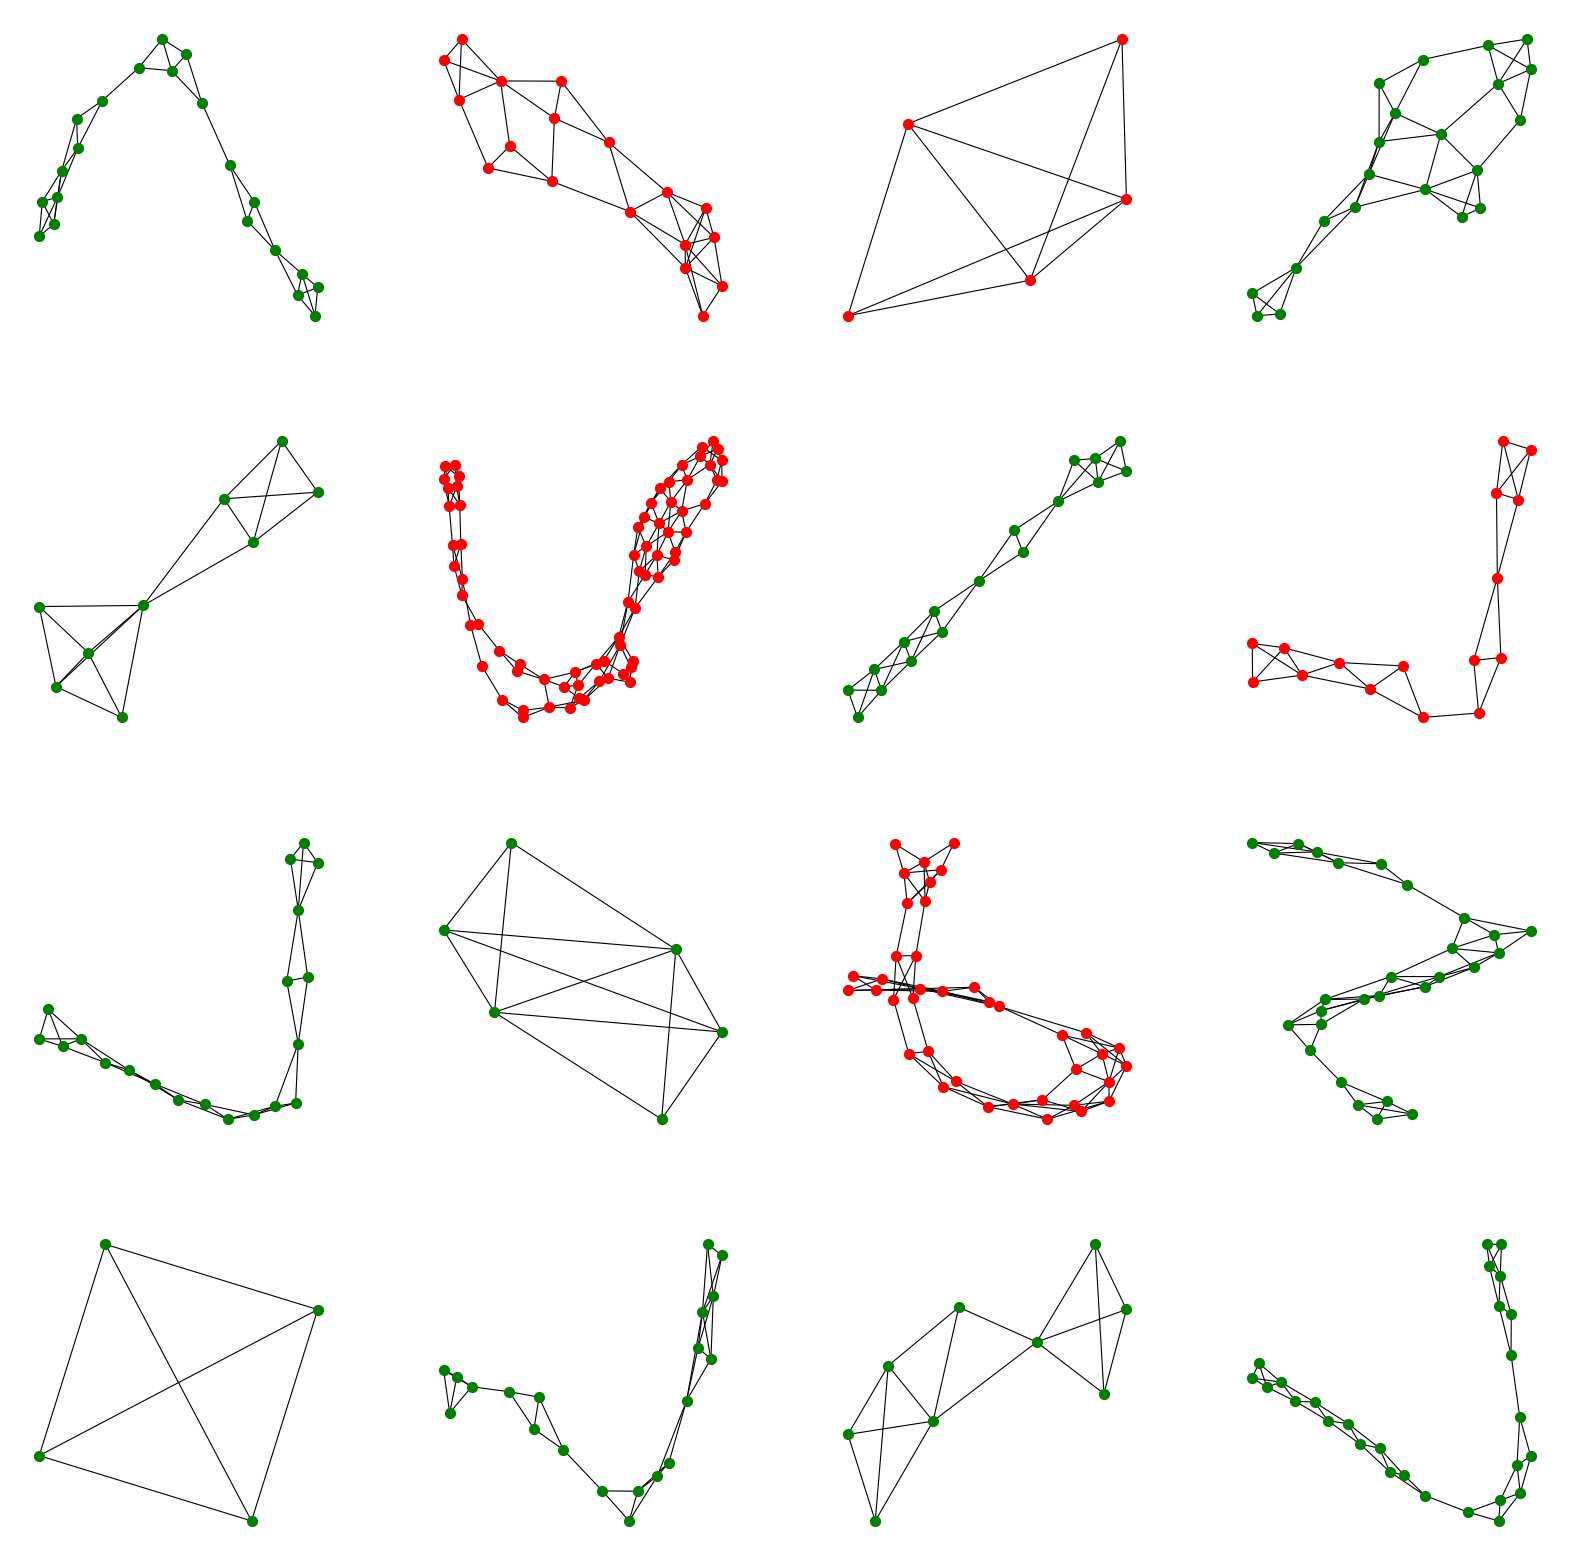

In [74]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i, data in enumerate(tu_data[-16:]):
    data = data.to(device)
    out = gcn(data.x, data.edge_index, data.batch)
    color = 'green' if out.argmax(dim=1) == data.y else 'red'
    ix = np.unravel_index(i, ax.shape)
    G = to_networkx(tu_data[i], to_undirected=True)
    nx.draw(G, ax=ax[ix], node_color=color, with_labels=False, pos =nx.spring_layout(G, seed = 0), node_size=50, width=0.8)
    

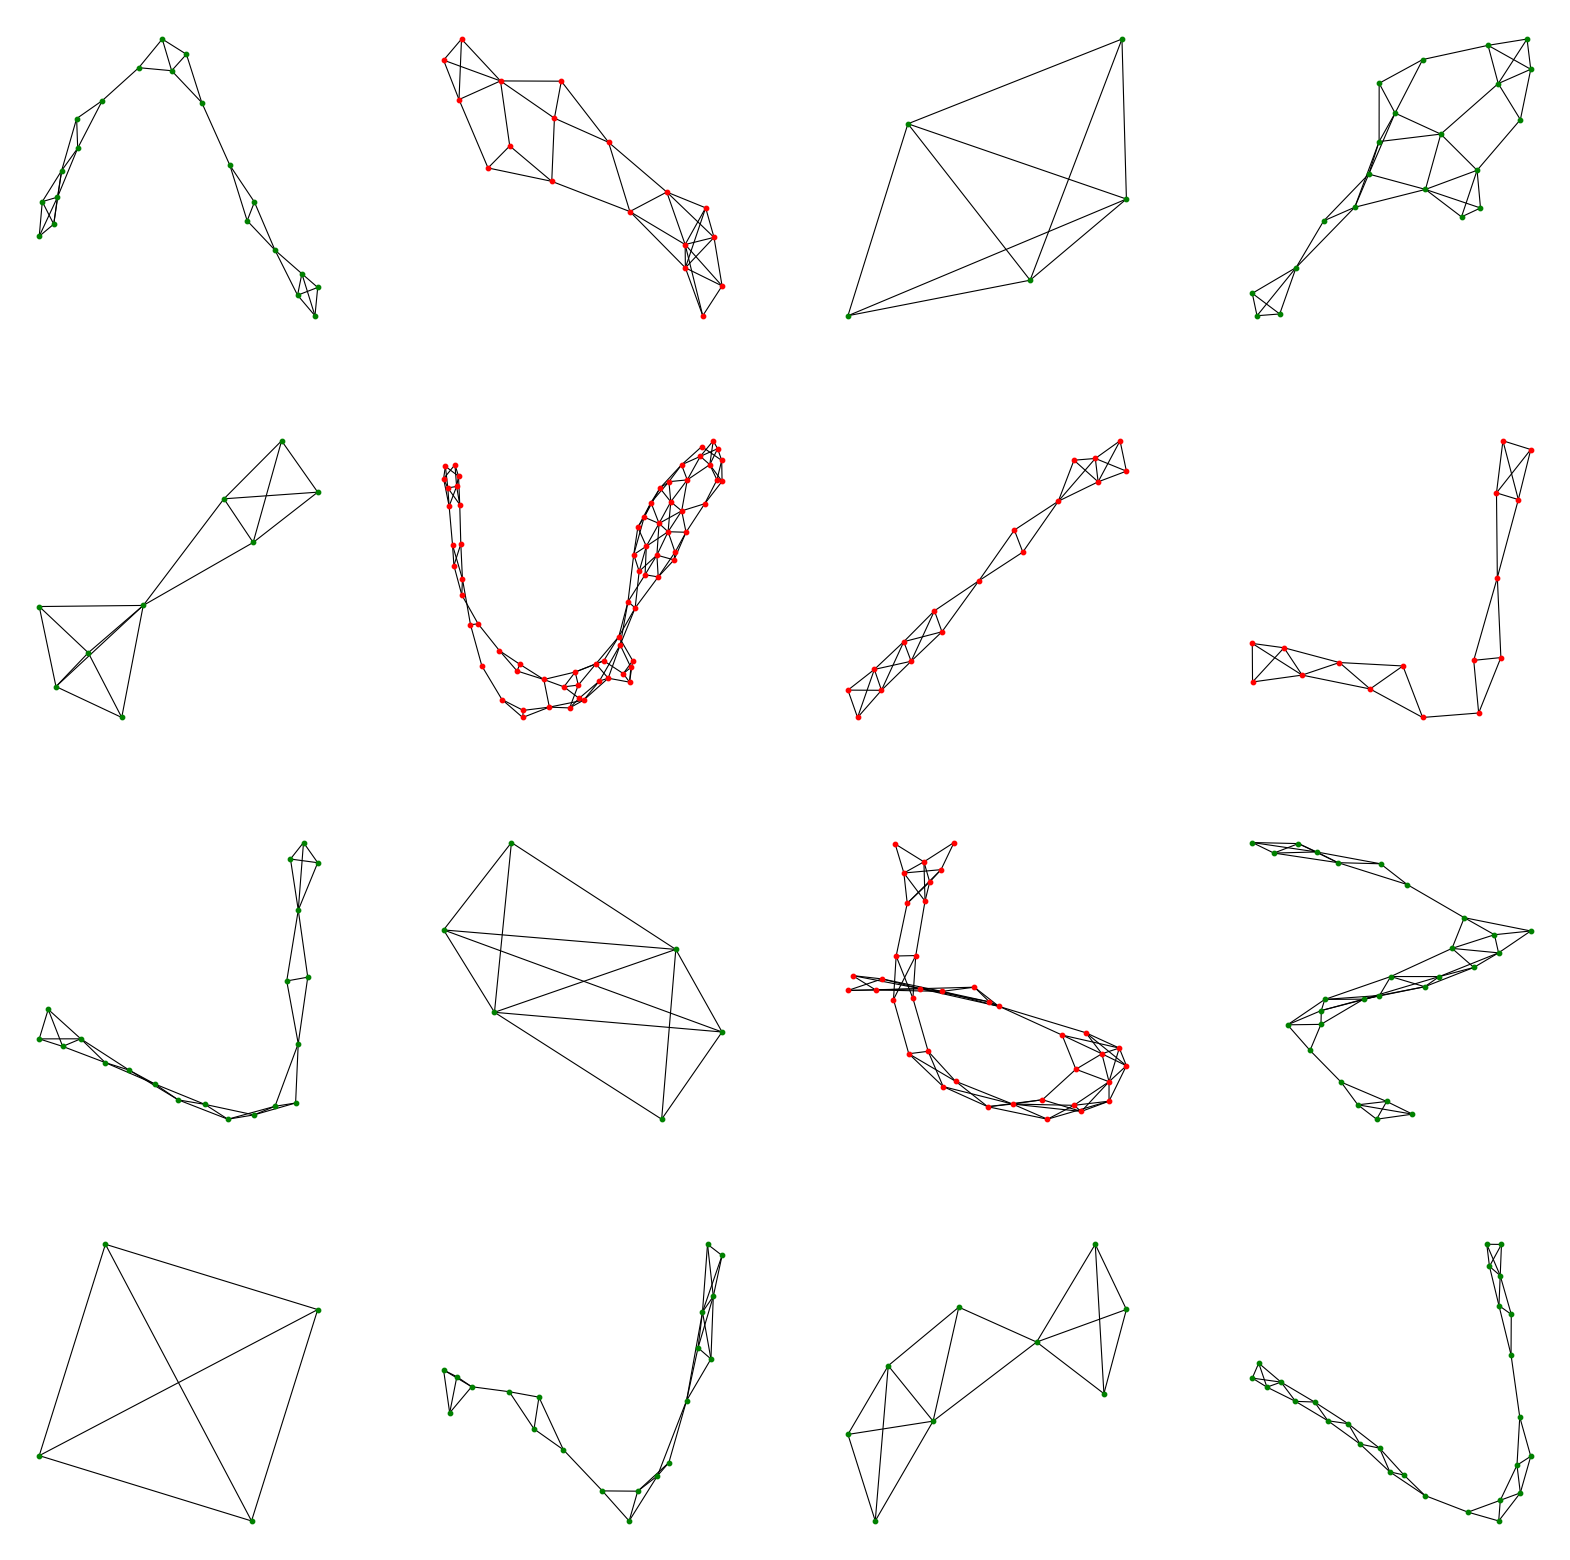

In [71]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i, data in enumerate(tu_data[-16:]):
    data = data.to(device)
    out = gin(data.x, data.edge_index, data.batch)
    color = 'green' if out.argmax(dim=1) == data.y else 'red'
    ix = np.unravel_index(i, ax.shape)
    G = to_networkx(tu_data[i], to_undirected=True)
    nx.draw(G, ax=ax[ix], node_color=color, with_labels=False, pos =nx.spring_layout(G, seed = 0), node_size=10, width=0.8)